Microsoft 

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
from collections import Counter
from scipy import signal




from pathlib import Path

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

import pickle 

from sklearn.neighbors import KNeighborsRegressor


from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.colors


import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D,ConvLSTM1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import tensorflow as tf


import pickle

from pathlib import Path




In [169]:
keys_for_grouping = [
"Calibration_start",
"Static_challenge_start",
"Seated_calibration",
"Static_seated_challenge",
"Exercise_challenge_start",
"Temporal_challenge_start",
"Temporal_seated_challenge"]

dictionary_path = "/Users/cslinxs/Desktop/all_weeks/summer24-lab/measurements_auscultatory_dictionary_ALL.pkl"
everything = {}



path_aurora_dataset = Path('/Users/cslinxs/Desktop/aurora_dataset/aurora_dataset/')
auscultatory_data = path_aurora_dataset / "measurements_auscultatory.tsv"

participants_data =  path_aurora_dataset / "participants.tsv"

basic_mesures_data = pd.read_csv(auscultatory_data,sep = '\t').dropna(subset=["waveform_file_path"]).dropna(subset=["sbp"]).dropna(subset=["dbp"]) 





with open(dictionary_path, 'rb') as handle:
    all_auscultatory_dic = pickle.load(handle)


bad_keys = []
for key, each_grouping in all_auscultatory_dic.items():
    if True in list(np.isnan(each_grouping[0])):
        bad_keys.append(key)
print(bad_keys)

for key in bad_keys:
    del all_auscultatory_dic[key]


## Charlton
participants_dps_csv_data = pd.read_csv("/Users/cslinxs/Desktop/all_weeks/pwdb_model_configs.csv")


['measurements_auscultatory/a064/a064.initial.Static_seated_challenge_1.tsv', 'measurements_auscultatory/a150/a150.return.Temporal_challenge_start_3.tsv', 'measurements_auscultatory/a328/a328.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a578/a578.initial.Static_challenge_start_1.tsv', 'measurements_auscultatory/a596/a596.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a642/a642.initial.Exercise_challenge_start_1.tsv', 'measurements_auscultatory/a648/a648.initial.Seated_calibration_1.tsv', 'measurements_auscultatory/a437/a437.initial.Exercise_challenge_start_2.tsv', 'measurements_auscultatory/a437/a437.return.Temporal_seated_challenge_2.tsv']


In [197]:
#all functions
def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list, default="EMPTY"),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]

def reject_outliers(data):
    return data[abs(data - np.mean(data)) <3 * np.std(data)]

def get_50_avg_coordinates(path):
    print(path)
    df = pd.read_csv(path,sep = '\t')   
    pos_pressure = df["pressure"]

    neglist = [ -x for x in pos_pressure]

    # ADD THE DROPPING DWOAN AND GETMIN BELLOW a LINE
    b, a = signal.butter(1, 0.002, analog=False)
    gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
    y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

    y_flater = np.array(y_flater)
    neglist = [ -x for x in y_flater]

    neg_max_values = max(neglist)
    neg_mix_values = min(neglist)
    mid_neg_value= neg_max_values - neg_mix_values

    min_height = neg_max_values - mid_neg_value*0.15 

    min_peaks, _ = find_peaks(neglist , height= min_height)

    
    most_accurate_mins = min_peaks
    diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

    mean_new_min = float(diffrences_new_min.mean())
    overlapped_means = pd.DataFrame( )

    nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)
    
    for i in range(len(most_accurate_mins)-1):
        
        current_pulse_width = int(most_accurate_mins[i+1]) -int(most_accurate_mins[i])
        if (current_pulse_width)< get_stats(diffrences_new_min)[4] and (current_pulse_width)> get_stats(diffrences_new_min)[1]:
            y_range  = list(range(int(most_accurate_mins[i]),int(most_accurate_mins[i+1])))
            y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]


            start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)
            y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]
            
            if len(y_rotated)>=int(mean_new_min):

                pulse_data_cut_short = pd.Series(list(y_rotated)[:int(mean_new_min)] )

                overlapped_means = pd.concat([overlapped_means, pulse_data_cut_short.rename(f"pulse {i}")], axis=1)
            else:
                
                pulse_data_and_Nan_filler = pd.Series(list(y_rotated)[:int(mean_new_min)] + list(nans_list[:int(mean_new_min) - len(y_rotated)]) )

                overlapped_means = pd.concat([overlapped_means, pulse_data_and_Nan_filler.rename(f"pulse {i}")], axis=1)

    overlapped_means['mean'] = overlapped_means.mean(axis=1)
    all_overlaps_means = (overlapped_means.mean(axis=1))
    resampled_y = signal.resample(all_overlaps_means, 50)
    return resampled_y


def get_person_activity_data(person_id):
    filler_to_person = basic_mesures_data[basic_mesures_data["pid"] == person_id]
    

    for each_path in filler_to_person["waveform_file_path"]:
        each_path_50_cords = get_50_avg_coordinates(path_aurora_dataset/each_path)
        # auscultatory_pressure.append(each_path_50_cords)
        everything[each_path] = [each_path_50_cords, filler_to_person[filler_to_person["waveform_file_path"] == each_path]["sbp"], 
                                 filler_to_person[filler_to_person["waveform_file_path"] == each_path]["dbp"] ]


# Filter by activity
# Filters to activty's first file no overlap
def filter_by_activity(activity_number=1):
    if activity_number ==-1:
        auscultatory_pressure =[item[0] for item in all_auscultatory_dic.values()]
        auscultatory_sbp = [item[1] for item in all_auscultatory_dic.values()]
        auscultatory_dbp = [item[2] for item in all_auscultatory_dic.values()]
        return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 
    activity_tested_on = activity_number
    

    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for key, each_grouping in all_auscultatory_dic.items():
        if not(f"{keys_for_grouping[activity_tested_on]}_1" in  key):
            del title_filtered_all_auscultatory_dic[key]
    auscultatory_pressure =[item[0] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_sbp = [item[1] for item in title_filtered_all_auscultatory_dic.values()]
    auscultatory_dbp = [item[2] for item in title_filtered_all_auscultatory_dic.values()]
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_sbp(SBP_range = (120,120), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_sbp)) if (float(auscultatory_dbp[sb])<=SBP_range[0] and float(auscultatory_sbp[sb])>SBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 

# Filters by systolic value
def filter_by_dbp(DBP_range = (70,80), activity_number=1):
    activity_tested_on = activity_number

    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp= filter_by_activity(activity_number)
    title_filtered_all_auscultatory_dic= dict(all_auscultatory_dic)
    for i in [sb for sb in range(len(auscultatory_dbp)) if (float(auscultatory_dbp[sb])<=DBP_range[0] and float(auscultatory_dbp[sb])>DBP_range[1]  ) ][::-1]:
        #print("hi")
        auscultatory_pressure.pop(i)
        auscultatory_sbp.pop(i)
        auscultatory_dbp.pop(i)
    return auscultatory_pressure,auscultatory_sbp,auscultatory_dbp 


def filter_charlton_subjects():
    charlton_point_dbp = [[],[],[]]

    # will track age,dbp values
    charlton_set_seen_duplicates =set()

    Charlton_dataset_csv = "/Users/cslinxs/Desktop/all_weeks/Charlton_dataset_csv"
    for files in os.listdir(Charlton_dataset_csv):
        if "_P.Csv" in files.title() and "Digital" in files.title():
            body_part = files.title().split("_")[1]
            function = files.title().split("_")[2]
            participants_csv_data = pd.read_csv(Charlton_dataset_csv+"/"+files)
            
            for i in range(len(participants_csv_data)):
                y_points = participants_csv_data.iloc[i][1:].dropna()
                
                resampled_y = signal.resample(y_points, 50)
                resampled_y = [int(y - min(resampled_y)) for y in resampled_y]
                
                if not(True in list(np.isnan(resampled_y))):
                    indivuals_set = (participants_dps_csv_data.get(" age [years]")[i],participants_dps_csv_data.get(" dbp [mmHg]")[i],participants_dps_csv_data.get(" pvr [Pa s/m^3]")[i])
                    if not(indivuals_set in charlton_set_seen_duplicates):
                        charlton_point_dbp[0].append(resampled_y)
                        charlton_point_dbp[1].append(participants_dps_csv_data.get(" dbp [mmHg]")[i])
                        charlton_point_dbp[2].append(participants_dps_csv_data.get(" mbp [mmHg]")[i])
                        
                        charlton_set_seen_duplicates.add(indivuals_set)
    return charlton_point_dbp[0], charlton_point_dbp[1]

def LinearRegression_plot_MAE( activity_number=1):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)

    all_points = np.array(auscultatory_pressure)
    all_points = all_points.reshape(all_points.shape[0], -1)

    plt.figure(figsize=(5, 5)) 
    neigh = LinearRegression()


    X_train, X_test, Y_train, Y_test = train_test_split(all_points, auscultatory_dbp, test_size=0.3)




    the_fit= neigh.fit(X_train, Y_train)

    y_predict= neigh.predict(X_test)

    plt.rcParams.update({'font.size': 10})

    plt.plot(Y_test, Y_test, color="grey", linewidth=2, alpha=0.9)


    plt.scatter(Y_test, list(y_predict),  color="red",  alpha=0.5,s=50 )
    plt.title(f"LinearRegression Activity: {keys_for_grouping[activity_number]}")
    plt.xlabel("Tested DBP value")
    plt.ylabel("Predicted DBP value")

    xmin, xmax, ymin, ymax = plt.axis()
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.4,s=f"MAE {round(mean_absolute_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin+(ymax-ymin)*0.2, s= f"RMS {round(root_mean_squared_error(Y_test, y_predict),2)}", fontsize=12)
    plt.text(xmax+0.25, ymin, s= f"r2 {round(r2_score(Y_test, y_predict),2)}", fontsize=12)
    plt.show()
    return round(mean_absolute_error(Y_test, y_predict),2)


def KNN_MAE_cross( activity_number=1, bp_variable = "s", n_neighbors=1, cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def LinearRegression_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp

    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        model = LinearRegression()

        X_test = X_test.reshape(X_test.shape[0], -1)

        the_fit = model.fit(X_train, Y_train)

        y_predict= model.predict(X_test)

        all_mea.append(round(mean_absolute_error(Y_test, y_predict),2))
        plt.rcParams.update({'font.size': 10})

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

                    

def CNN_MAE_cross( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        # auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        # bp_variable_val = auscultatory_dbp
        print("Use [CNN_MAE_cross_charlton] method")
        return None
    else: 
        auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = filter_by_activity(activity_number)
        if bp_variable=="d":
            bp_variable_val = auscultatory_dbp
        elif bp_variable=="s":
            bp_variable_val = auscultatory_sbp


    all_mea = []

    for i in range(0,len(auscultatory_pressure),cross_valid_space): 

        X = auscultatory_pressure[0:i] + auscultatory_pressure[i+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:i] +bp_variable_val[i+cross_valid_space:len(auscultatory_pressure)])
        
        X_other = auscultatory_pressure[i:i+cross_valid_space] 
        Y_other = np.array(bp_variable_val[i:i+cross_valid_space])
        
        X_train= np.array(X)
        Y_train= np.array(Y)

        X_test= np.array(X_other)
        Y_test= np.array(Y_other)

        X_test = X_test.reshape(X_test.shape[0], -1)
        Y_test = Y_test.reshape(Y_test.shape[0], -1)

        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(256, kernel_size=3, strides=3, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))
            optimizer = RMSprop(0.001)
            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])
            return model
        model = create_model()
        print(Y_train)
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
        

    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

def CNN_MAE_cross_charlton( activity_number=1, bp_variable = "s", cross_valid_space = 50):
    auscultatory_pressure, auscultatory_sbp, auscultatory_dbp = [], [], []
    
    bp_variable_val = None
    if bp_variable=="c":
        auscultatory_pressure, auscultatory_dbp = filter_charlton_subjects()
        bp_variable_val = auscultatory_dbp
    else: 
        print("Use [CNN_MAE_cross] method")
        return None


    all_mea = []
    cross_valid_space=50
    for i in range(0,len(auscultatory_pressure),50): 
        X = auscultatory_pressure[0:cross_valid_space] + auscultatory_pressure[cross_valid_space+cross_valid_space:len(auscultatory_pressure)]
        Y = np.array(bp_variable_val[0:cross_valid_space] +bp_variable_val[cross_valid_space+cross_valid_space:len(bp_variable_val)])
        
        X_other = auscultatory_pressure[cross_valid_space:cross_valid_space+50] 
        Y_other = np.array(bp_variable_val[cross_valid_space:cross_valid_space+50])

        
        X_test= np.array(X)
        Y_test= np.array(Y)
        
        X_train= np.array(X_other)
        Y_train= np.array(Y_other)



        def create_model():
            model = Sequential()
            model.add(Conv1D(filters=64, kernel_size=3,strides=3, activation='relu', input_shape=((X_train).shape[1], 1)))
            model.add(Dropout(0.5))
            model.add(Conv1D(256, kernel_size=3, strides=3, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Flatten())
            model.add(Dense(1))


            optimizer = RMSprop(0.001)

            model.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['mae',])

            return model
        model = create_model()
        
        history = model.fit(X_train, tf.stack(Y_train), epochs=50, validation_split=0.3)
        test_loss, test_accuracy = model.evaluate(X_test,tf.stack(Y_test) )


        all_mea.append(test_accuracy)
    return [get_stats(all_mea)[3], get_stats(all_mea)[4] - get_stats(all_mea)[3] ]

        

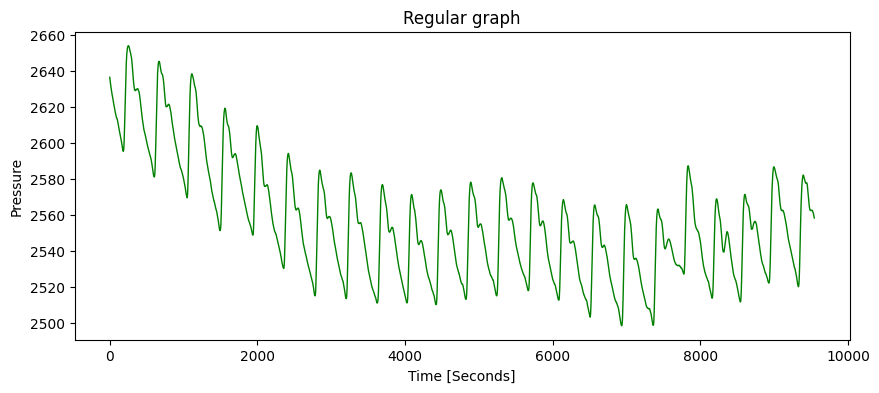

In [123]:
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(10, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "green")

plt.title("Regular graph")
# plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("Time [Seconds]")
plt.show()

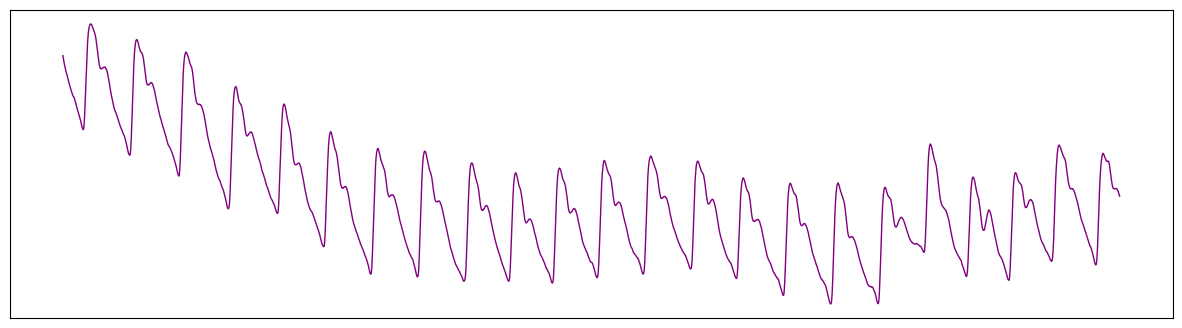

In [124]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

plt.figure(figsize=(15, 4)) 
plt.rcParams.update({'font.size': 10})

plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.xticks([])
plt.yticks([])

plt.show()

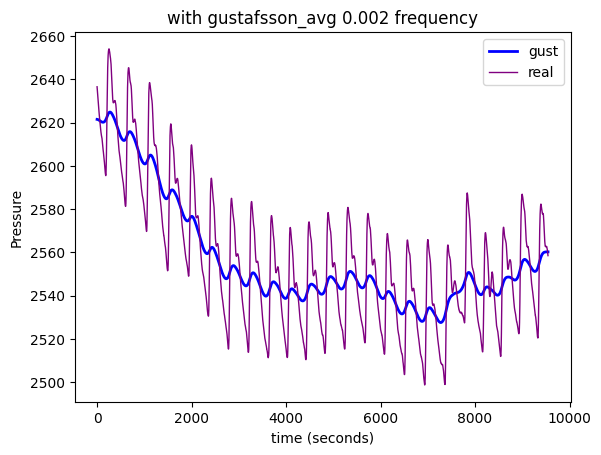

In [125]:
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


b, a = signal.butter(1, 0.002, analog=False)
gustafsson_avg = signal.filtfilt(b, a, x= pos_pressure, method="gust")
plt.plot(gustafsson_avg, 'b-', linewidth=2, label='gust',)
plt.plot(pos_pressure,  linewidth=1, label='real', color= "purple")

plt.title("with gustafsson_avg 0.002 frequency")
plt.legend(loc='best')
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.show()

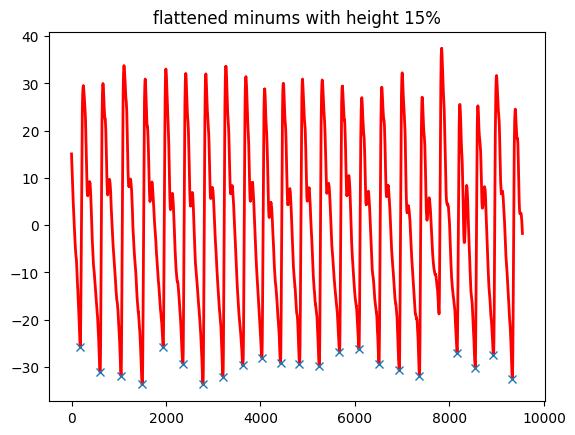

In [126]:

# df = pd.read_csv(path,sep = '\t')   
# pos_pressure = df["pressure"]

y_flater = [real_pre-abs( guston_avg) for real_pre, guston_avg in zip(pos_pressure, gustafsson_avg)]

y_flater = np.array(y_flater)
neglist = [ -x for x in y_flater]

neg_max_values = max(neglist)
neg_mix_values = min(neglist)
mid_neg_value= neg_max_values - neg_mix_values

min_height = neg_max_values - mid_neg_value*0.15 

min_peaks, _ = find_peaks(neglist , height= min_height, width=50)


plt.plot(y_flater, color="red", linewidth=2)
plt.plot(min_peaks, y_flater[min_peaks], "x",)
plt.title("flattened minums with height 15%")
plt.show()


In [127]:
most_accurate_mins = min_peaks
diffrences_new_min = reject_outliers(np.diff(most_accurate_mins))

mean_new_min = float(diffrences_new_min.mean())
overlapped_means = pd.DataFrame( )

nans_list = np.full(int(mean_new_min- get_stats(diffrences_new_min)[1]), np.nan)

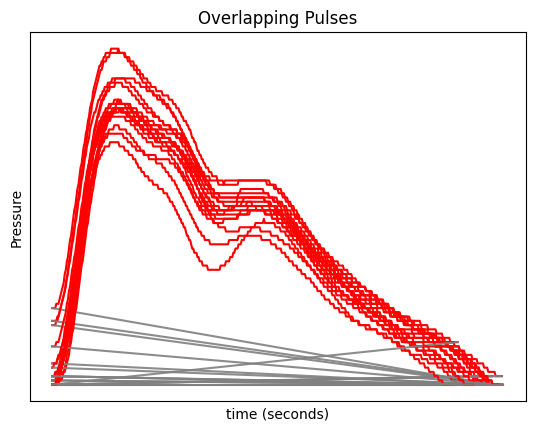

In [128]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_of_shift, color="red")
        plt.plot(start_end_line,color="grey" , alpha=0.9)


plt.title("Overlapping Pulses")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")
plt.xticks([])
plt.yticks([])

plt.show()

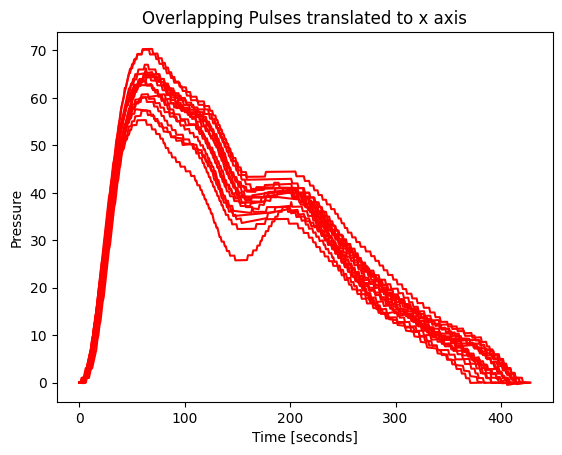

In [129]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(most_accurate_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]
 
        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))

        plt.plot(y_rotated, color="red")


plt.title("Overlapping Pulses translated to x axis")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")

plt.show()

/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


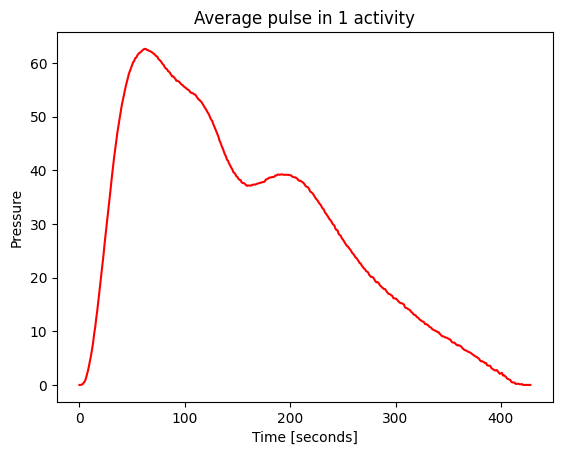

In [130]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']
plt.plot(all_overlaps_means, color='red')
plt.title("Average pulse in 1 activity")
plt.ylabel("Pressure")
plt.xlabel("Time [seconds]")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
plt.show()
all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']


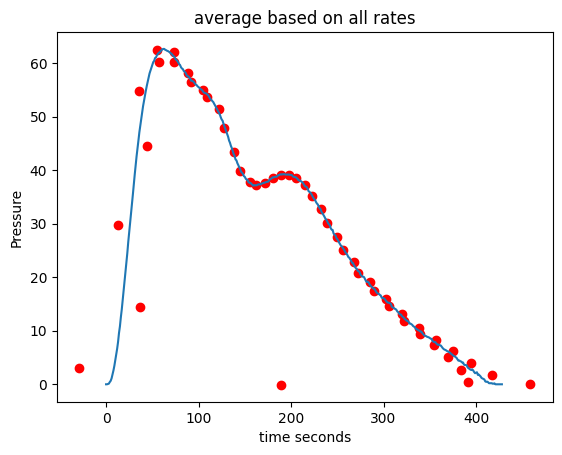

In [131]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

all_overlaps_means = [x for x in all_overlaps_means if str(x) != 'nan']

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50)


plt.plot(resampled_x,resampled_y,  'ro' )
plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

Demos are done.


Training Models:

Making the chart for aurora

In [ ]:

LinearRegression_MAE_cross(-1, "s",1000)

KNN_MAE_cross(-1, "s",1000)

CNN_MAE_cross(-1, "s",1000)

#or Run no overlap in participants , 0=Calibration_start recordings

LinearRegression_MAE_cross(0, "s",50)

KNN_MAE_cross(0, "s",50)

CNN_MAE_cross(0, "s",50)



Done with Auroa and Charlton

Now I want to makethe graph chart

In [144]:
LinearRegression_MAE_cross(-1, "c",10)


[1.0394117647058825, 0.21979858663130925]

In [145]:
KNN_MAE_cross(-1, "c",10)

[1.4749999999999999, 0.25821502667350704]

In [196]:
CNN_MAE_cross_charlton(-1, "c",10)


Epoch 1/50


/Users/cslinxs/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 6509.3550 - mae: 80.4984 - val_loss: 2636.1179 - val_mae: 50.9797
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2747.7766 - mae: 51.8095 - val_loss: 928.8204 - val_mae: 27.9269
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1180.3594 - mae: 31.3265 - val_loss: 381.1887 - val_mae: 16.3802
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 478.4727 - mae: 19.5141 - val_loss: 395.3809 - val_mae: 15.2778
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 389.8282 - mae: 16.4697 - val_loss: 371.9848 - val_mae: 16.2670
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 516.1379 - mae: 19.4112 - val_loss: 351.1310 - val_mae: 14.4725
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 432.0669 - mae: 18.1537 - val_loss: 404.6680 - val_mae: 15.4440
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 420.7958 - mae: 17.3925 - val_loss: 580.8953 - val_mae: 18.1708
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

[11.581608533859253, 1.8666992454607083]

In [ ]:
LinearRegression_MAE_cross(1,"c")

[1.4375, 0.3554838252297845]